In [1]:
TEST = '/kaggle/input/ff-frames/test'
TRAIN = '/kaggle/input/ff-frames/train'
VAL = '/kaggle/input/ff-frames/val'

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 168MB/s]


In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (48, 48)

def embed(model, filename: str):
    try:
        with Image.open(fp=filename, mode='r') as image:
            return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)
    except: 
        print(filename)
        return None


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if not input_file.endswith('.svg') if index < 100]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') if isdir(folder)}
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
val_dict = {basename(folder) : folder + '/*.*' for folder in iglob(VAL + '/*') if isdir(folder)}
val_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in val_dict.items()]))
train_df = pd.concat(axis='index', objs=[train_df, val_df])
print('done in {}'.format(arrow.now() - time_start))

encoded 100 rows of FAKE  in 0:00:13.383076
encoded 100 rows of REAL  in 0:00:13.673816
encoded 100 rows of FAKE  in 0:00:13.259165
encoded 100 rows of REAL  in 0:00:12.966219
encoded 100 rows of FAKE  in 0:00:13.285420
encoded 100 rows of REAL  in 0:00:13.014987
done in 0:01:19.654554


In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag,FAKE,REAL
proportion,0.5,0.5


In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.002s...
[t-SNE] Computed neighbors for 400 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 3.874568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.924778
[t-SNE] KL divergence after 1000 iterations: 0.768266
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.549982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.073719
[t-SNE] KL divergence after 1000 iterations: 0.408395


In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(len(train_df) - 1, 10000)))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: faces', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(zero_division=0.0, y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

model fit in 420 iterations
accuracy: 0.5800
f1: 0.5793
              precision    recall  f1-score   support

        FAKE       0.59      0.54      0.56       100
        REAL       0.57      0.62      0.60       100

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.58      0.58      0.58       200



<Axes: xlabel='probability', ylabel='Count'>

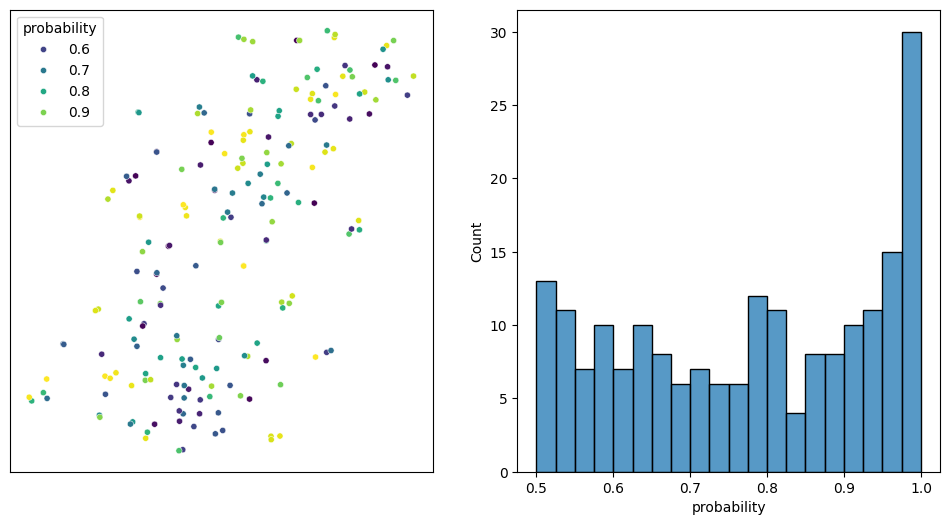

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', s=20)
ax[0].set(xlabel=None)
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)